In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(21664, 28)
(21664, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [7]:
## Entries where FL is swinging
idxs = np.where(X_motion[:, 21] == 1)[0]
X_motion_FL_swinging = X_motion[idxs]
Y_motion_FL_swinging = Y_motion[idxs]

## Predict FL foot -> x

In [8]:
X_motion_FL_swinging.shape

(10835, 28)

In [9]:
Y_motion_FL_swinging.shape

(10835, 4)

In [18]:
X_motion_FL_swinging[0:10, 0]

array([0. , 0. , 0. , 0.1, 0.1, 0.2, 0.2, 0.2, 0.1, 0.1])

In [20]:
Y_motion_FL_swinging[0:100, :]

array([[ 0.23179327,  0.14004969, -0.24871657, -0.13906732],
       [ 0.23104885,  0.15769172, -0.24856249, -0.15704255],
       [ 0.23074399,  0.16525878, -0.24879558, -0.16299948],
       [ 0.23853637,  0.16813658, -0.24077563, -0.16782352],
       [ 0.24136077,  0.16968122, -0.23783159, -0.16965005],
       [ 0.24837992,  0.17022867, -0.230644  , -0.17071504],
       [ 0.25119232,  0.17052483, -0.22783145, -0.17114184],
       [ 0.24325481,  0.17178673, -0.2357449 , -0.17005344],
       [ 0.24335603,  0.17096633, -0.23571748, -0.1708254 ],
       [ 0.24892094,  0.17005349, -0.23077753, -0.17161225],
       [ 0.25541974,  0.17022228, -0.22425446, -0.17160375],
       [ 0.24666577,  0.17136508, -0.23275674, -0.17048918],
       [ 0.24391034,  0.17099282, -0.23522791, -0.17093962],
       [ 0.24191274,  0.17106493, -0.23727962, -0.1706941 ],
       [ 0.25227144,  0.17042367, -0.22693028, -0.17161657],
       [ 0.25325624,  0.17057621, -0.2257491 , -0.17159012],
       [ 0.24414811,  0.

### Linear Regression

In [12]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # prev velocity command
               X_motion_FL_swinging[:, -3:], # commanded velocity command
               X_motion_FL_swinging[:, 3:9],
               X_motion_FL_swinging[:, 9:11], # FL (x,y) position
               X_motion_FL_swinging[:, 12:14], # FR (x,y) position
               X_motion_FL_swinging[:, 15:17], # RL (x,y) position
               X_motion_FL_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_x = LinearRegression()

# Fit the model
model_fl_relative_support_x.fit(X_train, Y_train)
    
# Predict
predictions = model_fl_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9757327729177082
RMSE:  0.005315120146223958
The lowest error is:  1.6693074942619734e-06
The highest error is:  0.035960088513911415
The avg. error is:  0.0031757792225244274


In [13]:
model_fl_relative_support_x.coef_

array([[ 0.01667945, -0.0095603 ,  0.00521299,  0.09306255, -0.00911753,
        -0.00203325,  0.0182604 , -0.01080819, -0.05596843, -0.00894092,
        -0.02070063, -0.00509915,  0.14681081, -0.03892616,  0.03690105,
         0.04300687,  0.02754763,  0.02087922,  0.12184345, -0.03123797]])

In [14]:
model_fl_relative_support_x.intercept_

array([0.22955842])

Text(0, 0.5, 'Predictions')

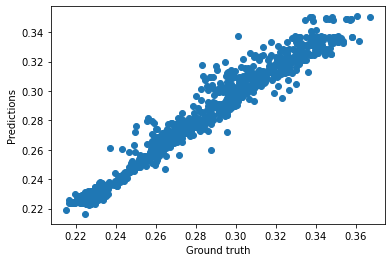

In [15]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [21]:
#%store model_fl_relative_support_x

In [22]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [23]:
# Save model
#joblib.dump(model_fl_relative_support_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_x.sav")

### Predict FL foot -> y

In [16]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # prev velocity command
               X_motion_FL_swinging[:, -3:], # commanded velocity command
               X_motion_FL_swinging[:, 3:9],
               X_motion_FL_swinging[:, 9:11], # FL (x,y) position
               X_motion_FL_swinging[:, 12:14], # FR (x,y) position
               X_motion_FL_swinging[:, 15:17], # RL (x,y) position
               X_motion_FL_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9594467946831403
RMSE:  0.004967847154298435
The lowest error is:  1.0893593702654414e-06
The highest error is:  0.04631625785838564
The avg. error is:  0.0027422087486181266


In [22]:
model_fl_relative_support_y.coef_

array([[-0.0055751 ,  0.06842117,  0.03693887,  0.02111909,  0.2211869 ,
         0.02227369, -0.00835656, -0.16485621, -0.03163174, -0.00659666,
        -0.04289936,  0.00601045,  0.00410085, -0.15343558]])

In [23]:
model_fl_relative_support_y.intercept_

array([-8.44438176e-06])

Text(0, 0.5, 'Predictions')

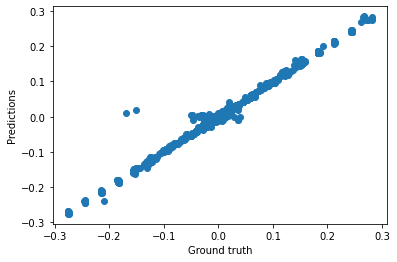

In [24]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [25]:
#%store model_fl_relative_support_y

In [24]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [25]:
# Save model
#joblib.dump(model_fl_relative_support_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_y.sav")